<h1> Predicting Stocks </h1>

Datasets: https://www.kaggle.com/datasets/rprkh15/sp500-stock-prices

In this project we will use AMZN (Amazon), EBAY (eBay), META (Meta) and SEE (Sealed Air) data.

<h2> Project goals </h2>

Deal with unevenly spaced time series using a neural network.

<h3> Column information </h3>

Date: The date is in the format yy-mm-dd

Open: Price of the stock when the market opens

High: Highest price reached in the day

Low: Lowest price reached in the day

Close: Price of the stock when the market closes

Volume: Number of shares traded in a day

Dividends: The dividends of the stock

Stock Splits: The stock splits of the company. In a stock split, a company divides its existing stock into multiple shares to boost liquidity.

<h3> Imports </h3>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pprint import pprint
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
import time
import keras_tuner as kt
import tensorflow as tf
import keras
from keras.models import Sequential
from sklearn.metrics import mean_squared_error

<h2> Exploratory Data Analysis (EDA) </h2>

In [2]:
df_amzn = pd.read_csv('data/AMZN.csv')
df_ebay = pd.read_csv('data/EBAY.csv')
df_meta = pd.read_csv('data/META.csv')
df_see = pd.read_csv('data/SEE.csv')

In [3]:
df_amzn.head() #, df_ebay.head(), df_meta.head(), df_see.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,1443120000,0,0.0
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,294000000,0,0.0
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,122136000,0,0.0
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,109344000,0,0.0
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,377064000,0,0.0


Dataframes were created correctly.

In [4]:
df_amzn.isnull().sum().sum(), df_ebay.isnull().sum().sum(), df_meta.isnull().sum().sum(), df_see.isnull().sum().sum()

(0, 0, 0, 0)

There is no nan values in the dataframes.

In [5]:
df_amzn.shape[0], df_ebay.shape[0], df_meta.shape[0], df_see.shape[0]

(6331, 5988, 2553, 10671)

In [6]:
df_amzn[['Date']].nunique()[0], df_ebay[['Date']].nunique()[0], df_meta[['Date']].nunique()[0], df_see[['Date']].nunique()[0]

(6331, 5988, 2553, 10671)

Dates are unique.

In [7]:
df_amzn['Date'].is_monotonic_increasing, df_ebay['Date'].is_monotonic_increasing, df_meta['Date'].is_monotonic_increasing, df_see['Date'].is_monotonic_increasing

(True, True, True, True)

Dates are in an increasing order.

We will set a date as an index later.

In [8]:
df_amzn['Date'] = pd.to_datetime(df_amzn['Date'])
df_ebay['Date'] = pd.to_datetime(df_ebay['Date'])
df_meta['Date'] = pd.to_datetime(df_meta['Date'])
df_see['Date'] = pd.to_datetime(df_see['Date'])

In [9]:
df_amzn.info() # df_ebay.info(), df_meta.info(), df_see.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6331 entries, 0 to 6330
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          6331 non-null   datetime64[ns]
 1   Open          6331 non-null   float64       
 2   High          6331 non-null   float64       
 3   Low           6331 non-null   float64       
 4   Close         6331 non-null   float64       
 5   Volume        6331 non-null   int64         
 6   Dividends     6331 non-null   int64         
 7   Stock Splits  6331 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 395.8 KB


Now features have the correct types.

Unfortunately, the shapes are not even so it will be not easy to calculate correlations of prices.

In [10]:
df_amzn.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,6331.000000,6331.000000,6331.000000,6331.000000,6.331000e+03,6331.0,6331.000000
mean,29.404726,29.745135,29.027439,29.392504,1.446918e+08,0.0,0.004265
std,46.913916,47.440509,46.317139,46.875811,1.415407e+08,0.0,0.256629
min,0.070313,0.072396,0.065625,0.069792,9.744000e+06,0.0,0.000000
25%,1.963500,2.000000,1.934250,1.967500,7.030300e+07,0.0,0.000000
50%,5.927000,6.016500,5.850000,5.924500,1.077160e+08,0.0,0.000000
75%,33.222750,33.537001,32.912500,33.181000,1.636940e+08,0.0,0.000000
max,187.199997,188.654007,184.839493,186.570496,2.086584e+09,0.0,20.000000


In [11]:
df_ebay.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,5988.000000,5988.000000,5988.000000,5988.000000,5.988000e+03,5988.000000,5988.000000
mean,20.399151,20.680647,20.129533,20.404020,3.512111e+07,0.000394,0.001900
std,15.382824,15.560195,15.219678,15.383951,3.390790e+07,0.008238,0.066685
min,0.465459,0.488419,0.421627,0.484245,2.129200e+06,0.000000,0.000000
25%,9.254912,9.424731,9.155225,9.307762,1.266258e+07,0.000000,0.000000
50%,15.268728,15.467099,15.032282,15.228652,2.823496e+07,0.000000,0.000000
75%,27.070802,27.408831,26.758961,27.082705,4.509951e+07,0.000000,0.000000
max,80.067682,80.285222,79.009595,79.691902,5.776987e+08,0.220000,3.000000


In [12]:
df_meta.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,2553.000000,2553.000000,2553.000000,2553.000000,2.553000e+03,2553.0,2553.0
mean,148.425104,150.255589,146.564391,148.444446,3.093002e+07,0.0,0.0
std,88.792620,89.909429,87.714140,88.824150,2.719816e+07,0.0,0.0
min,18.080000,18.270000,17.549999,17.730000,5.913100e+06,0.0,0.0
25%,76.739998,77.529999,75.750000,76.669998,1.596820e+07,0.0,0.0
50%,143.149994,145.669998,141.619995,144.190002,2.287930e+07,0.0,0.0
75%,194.259995,196.910004,191.470001,193.639999,3.592500e+07,0.0,0.0
max,381.679993,384.329987,378.809998,382.179993,5.735764e+08,0.0,0.0


In [13]:
df_see.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,10671.000000,10671.000000,10671.000000,10671.000000,1.067100e+04,10671.000000,10671.000000
mean,16.674133,16.963768,16.585196,16.775771,1.049874e+06,0.000855,0.001125
std,15.431637,15.481303,15.161155,15.321558,1.388758e+06,0.011036,0.054752
min,0.000000,0.145249,0.141018,0.141018,0.000000e+00,0.000000,0.000000
25%,2.222365,2.251301,2.205002,2.245514,2.548000e+05,0.000000,0.000000
50%,15.463958,15.649876,15.232462,15.456550,7.680000e+05,0.000000,0.000000
75%,21.961083,22.205719,21.701211,21.967103,1.424200e+06,0.000000,0.000000
max,69.773979,70.491655,69.146016,69.943428,5.301120e+07,0.200000,4.000000


As we can see measures vary by dataframe. We can expect plots of various shapes.

In [14]:
(df_amzn['Date'] - df_amzn['Date'].shift(1)).value_counts()

1 days    4959
3 days    1143
4 days     167
2 days      58
5 days       2
7 days       1
Name: Date, dtype: int64

In [15]:
# print((df_ebay['Date'] - df_ebay['Date'].shift(1)).value_counts())
# print((df_meta['Date'] - df_meta['Date'].shift(1)).value_counts())
# print((df_see['Date'] - df_see['Date'].shift(1)).value_counts())

As we can see we are dealing with irregular time intervals. We may try to deal with this later.

Let's set a date as an index.

In [16]:
df_amzn = df_amzn.set_index('Date')
df_ebay = df_ebay.set_index('Date')
df_meta = df_meta.set_index('Date')
df_see = df_see.set_index('Date')

In [17]:
df_amzn.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1997-05-15,0.121875,0.125000,0.096354,0.097917,1443120000,0,0.0
1997-05-16,0.098438,0.098958,0.085417,0.086458,294000000,0,0.0
1997-05-19,0.088021,0.088542,0.081250,0.085417,122136000,0,0.0
1997-05-20,0.086458,0.087500,0.081771,0.081771,109344000,0,0.0
1997-05-21,0.081771,0.082292,0.068750,0.071354,377064000,0,0.0


<h3> Data Visualization </h3>

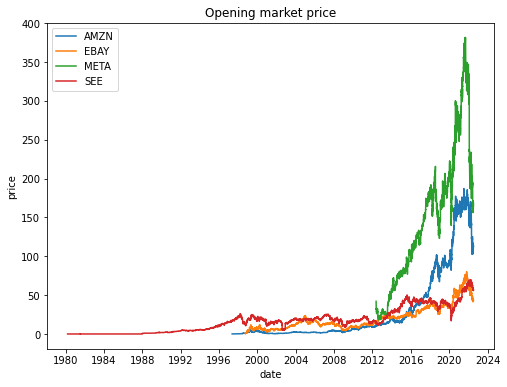

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
half_year_locator = mdates.YearLocator(4)
ax.xaxis.set_major_locator(half_year_locator)
plt.title('Opening market price')
plt.xlabel('date')
plt.ylabel('price')
ax.plot(df_amzn.index, df_amzn['Open'], label = 'AMZN')
ax.plot(df_ebay.index, df_ebay['Open'], label = "EBAY")
ax.plot(df_meta.index, df_meta['Open'], label = "META")
ax.plot(df_see.index, df_see['Open'], label = "SEE")
plt.legend()
plt.show()

As we can see, last years seems to be the most crucial. Let's make another plot, which will be focused on this period.

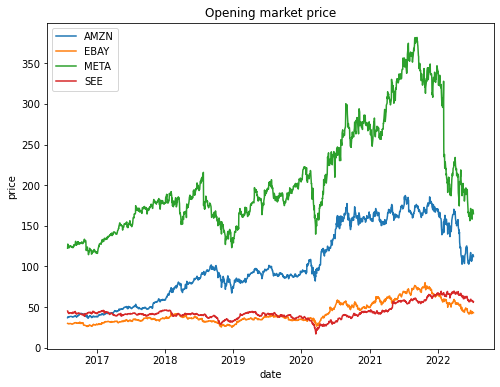

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
half_year_locator = mdates.YearLocator(1)
ax.xaxis.set_major_locator(half_year_locator)
plt.title('Opening market price')
plt.xlabel('date')
plt.ylabel('price')
ax.plot(df_amzn.index[-1500:], df_amzn['Open'][-1500:], label = 'AMZN')
ax.plot(df_ebay.index[-1500:], df_ebay['Open'][-1500:], label = "EBAY")
ax.plot(df_meta.index[-1500:], df_meta['Open'][-1500:], label = "META")
ax.plot(df_see.index[-1500:], df_see['Open'][-1500:], label = "SEE")
plt.legend()
plt.show()

We can plot moving averages to see the trends much easier.

In [20]:
df_amzn['MO25'] = df_amzn['Open'].rolling(25).mean()
df_ebay['MO25'] = df_ebay['Open'].rolling(25).mean()
df_meta['MO25'] = df_meta['Open'].rolling(25).mean()
df_see['MO25'] = df_see['Open'].rolling(25).mean()

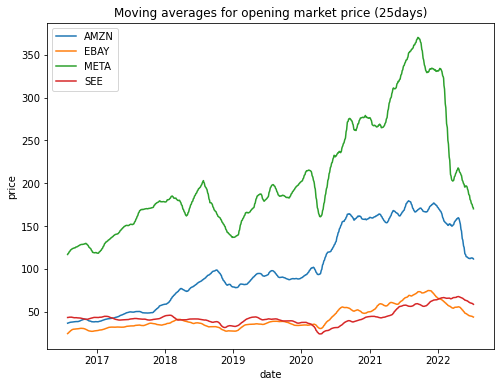

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
half_year_locator = mdates.YearLocator(1)
ax.xaxis.set_major_locator(half_year_locator)
plt.title('Moving averages for opening market price (25days)')
plt.xlabel('date')
plt.ylabel('price')
ax.plot(df_amzn.index[-1500:], df_amzn['MO25'][-1500:], label = 'AMZN')
ax.plot(df_ebay.index[-1500:], df_ebay['MO25'][-1500:], label = "EBAY")
ax.plot(df_meta.index[-1500:], df_meta['MO25'][-1500:], label = "META")
ax.plot(df_see.index[-1500:], df_see['MO25'][-1500:], label = "SEE")
plt.legend()
plt.show()

As we can see each concern had a drop in late 2018, early 2020, and 2022. According to cnbc.com stock in late 2018 fell, because "investors feared a central bank ready to tighten monetary policy, a slowing economy, and an intensifying trade war between the U.S. and China." Secondly, about an early 2020 crash, Wikipedia says that it was due to Covid-19. A Russo-Ukrainian War and additionally next years of pandemic result in a global economic recession and a generally negative impact on economies in 2022, Wikipedia says.

It's also worth noticing that Meta's stock prices were most valuable, and Amazon's were higher than pretty similar others.

Sources:

https://www.cnbc.com/2021/12/08/why-this-month-echoes-december-2018-when-stocks-plummeted.html

https://en.wikipedia.org/wiki/2020_stock_market_crash

https://en.wikipedia.org/wiki/2022_stock_market_decline

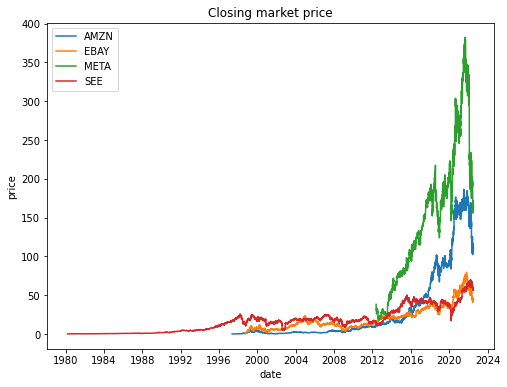

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
half_year_locator = mdates.YearLocator(4)
ax.xaxis.set_major_locator(half_year_locator)
plt.title('Closing market price')
plt.xlabel('date')
plt.ylabel('price')
ax.plot(df_amzn.index, df_amzn['Close'], label = 'AMZN')
ax.plot(df_ebay.index, df_ebay['Close'], label = "EBAY")
ax.plot(df_meta.index, df_meta['Close'], label = "META")
ax.plot(df_see.index, df_see['Close'], label = "SEE")
plt.legend()
plt.show()

The plot looks very similar to the Opening one. The conclusion is the same.

Let's look at the volume of stock traded.

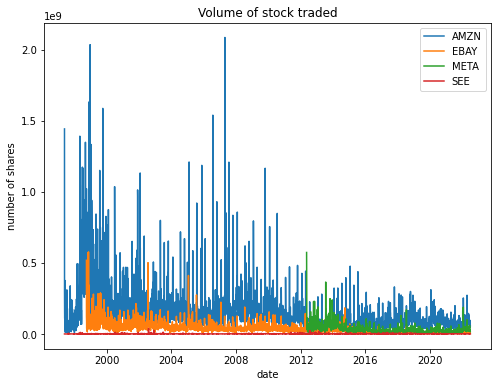

In [23]:
since_date = df_amzn.index[0]

fig, ax = plt.subplots(figsize=(8, 6))
half_year_locator = mdates.YearLocator(4)
ax.xaxis.set_major_locator(half_year_locator)
plt.title('Volume of stock traded')
plt.xlabel('date')
plt.ylabel('number of shares')
ax.plot(df_amzn.index, df_amzn['Volume'], label = 'AMZN')
ax.plot(df_ebay.index, df_ebay['Volume'], label = "EBAY")
ax.plot(df_meta.index, df_meta['Volume'], label = "META")
ax.plot(df_see.index[df_see.index>=pd.to_datetime(since_date)], df_see['Volume'][df_see.index>=pd.to_datetime(since_date)], label = "SEE")
plt.legend()
plt.show()

The yaxis scale isn't good for all of the concerns so let's prepare another plots for them.

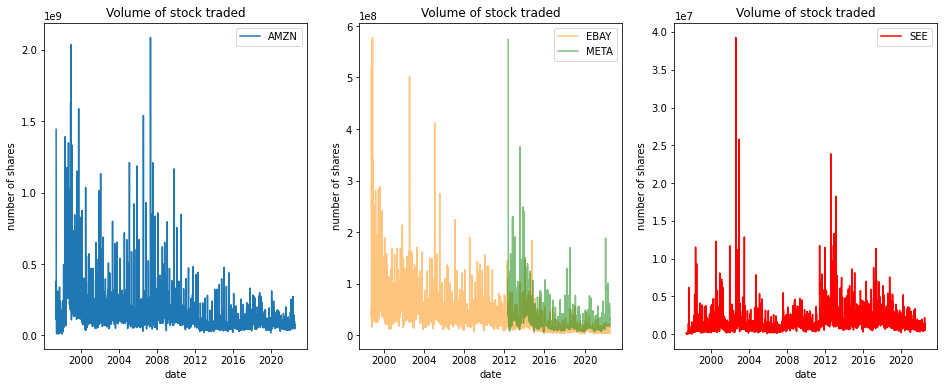

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
half_year_locator = mdates.YearLocator(4)

for i in range(len(axs)):
    if i == 0:
        axs[i].xaxis.set_major_locator(half_year_locator)
        axs[i].set_title('Volume of stock traded')
        axs[i].set_xlabel('date')
        axs[i].set_ylabel('number of shares')
        axs[i].plot(df_amzn.index, df_amzn['Volume'], label = 'AMZN')
        axs[i].legend()
    elif i == 1:
        axs[i].xaxis.set_major_locator(half_year_locator)
        axs[i].set_title('Volume of stock traded')
        axs[i].set_xlabel('date')
        axs[i].set_ylabel('number of shares')
        axs[i].plot(df_ebay.index, df_ebay['Volume'], label = "EBAY", color='darkorange', alpha=0.5)
        axs[i].plot(df_meta.index, df_meta['Volume'], label = "META", color='green', alpha=0.5)
        axs[i].legend()
    else:
        axs[i].xaxis.set_major_locator(half_year_locator)
        axs[i].set_title('Volume of stock traded')
        axs[i].set_xlabel('date')
        axs[i].set_ylabel('number of shares')
        axs[i].plot(df_see.index[df_see.index>=pd.to_datetime(since_date)], df_see['Volume'][df_see.index>=pd.to_datetime(since_date)], label = "SEE", color='red')
        axs[i].legend()

Let's plot the moving averages for volume.

In [25]:
df_amzn['MV100'] = df_amzn['Volume'].rolling(100).mean()
df_ebay['MV100'] = df_ebay['Volume'].rolling(100).mean()
df_meta['MV100'] = df_meta['Volume'].rolling(100).mean()
df_see['MV100'] = df_see['Volume'].rolling(100).mean()

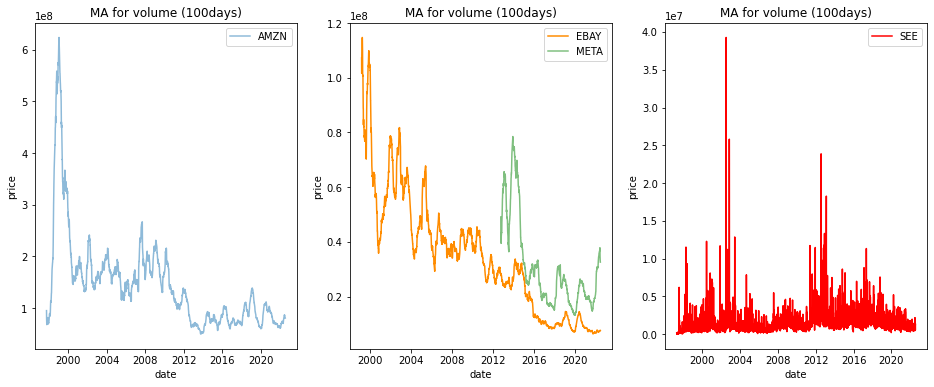

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
half_year_locator = mdates.YearLocator(4)

for i in range(len(axs)):
    if i == 0:
        axs[i].xaxis.set_major_locator(half_year_locator)
        axs[i].set_title('MA for volume (100days)')
        axs[i].set_xlabel('date')
        axs[i].set_ylabel('price')
        axs[i].plot(df_amzn.index, df_amzn['MV100'], label = 'AMZN', alpha=0.5)
        axs[i].legend()
    elif i == 1:
        axs[i].xaxis.set_major_locator(half_year_locator)
        axs[i].set_title('MA for volume (100days)')
        axs[i].set_xlabel('date')
        axs[i].set_ylabel('price')
        axs[i].plot(df_ebay.index, df_ebay['MV100'], label = "EBAY", color='darkorange')
        axs[i].plot(df_meta.index, df_meta['MV100'], label = "META", color='green', alpha=0.5)
        axs[i].legend()
    else:
        axs[i].xaxis.set_major_locator(half_year_locator)
        axs[i].set_title('MA for volume (100days)')
        axs[i].set_xlabel('date')
        axs[i].set_ylabel('price')
        axs[i].plot(df_see.index[df_see.index>=pd.to_datetime(since_date)], df_see['Volume'][df_see.index>=pd.to_datetime(since_date)], label = "SEE", color='red')
        axs[i].legend()

The Plot shows that Amazon stocks are generally traded more than other concerns. Sealed Air's stocks seem to be traded less than others. For each company, we can observe a rather downward trend in recent years.

For a better company comparison, we will plot a market cap (Open * Volume).

In [27]:
df_amzn['Market Cap'] = df_amzn['Open'] * df_amzn['Volume']
df_ebay['Market Cap'] = df_ebay['Open'] * df_ebay['Volume']
df_meta['Market Cap'] = df_meta['Open'] * df_meta['Volume']
df_see['Market Cap'] = df_see['Open'] * df_see['Volume']

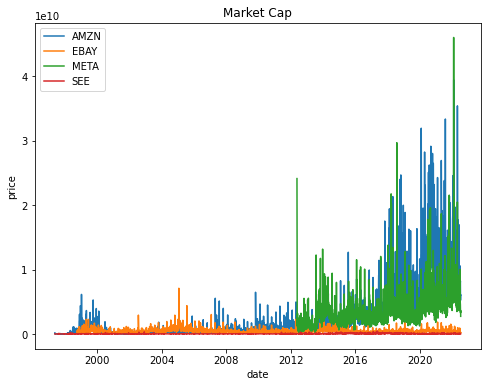

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
half_year_locator = mdates.YearLocator(4)
ax.xaxis.set_major_locator(half_year_locator)
plt.title('Market Cap')
plt.xlabel('date')
plt.ylabel('price')
ax.plot(df_amzn.index, df_amzn['Market Cap'], label = 'AMZN')
ax.plot(df_ebay.index, df_ebay['Market Cap'], label = "EBAY")
ax.plot(df_meta.index, df_meta['Market Cap'], label = "META")
ax.plot(df_see.index[df_see.index>=pd.to_datetime(since_date)], df_see['Market Cap'][df_see.index>=pd.to_datetime(since_date)], label = "SEE")
plt.legend()
plt.show()

Again, let's change the scales.

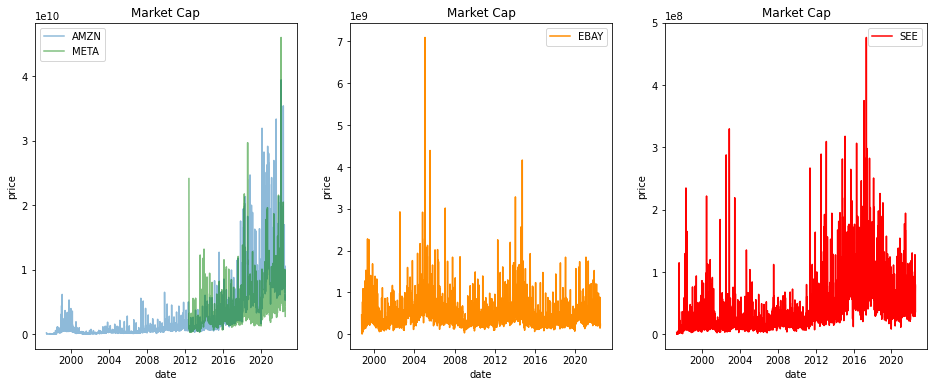

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
half_year_locator = mdates.YearLocator(4)

for i in range(len(axs)):
    if i == 0:
        axs[i].xaxis.set_major_locator(half_year_locator)
        axs[i].set_title('Market Cap')
        axs[i].set_xlabel('date')
        axs[i].set_ylabel('price')
        axs[i].plot(df_amzn.index, df_amzn['Market Cap'], label = 'AMZN', alpha=0.5)
        axs[i].plot(df_meta.index, df_meta['Market Cap'], label = "META", color='green', alpha=0.5)
        axs[i].legend()
    elif i == 1:
        axs[i].xaxis.set_major_locator(half_year_locator)
        axs[i].set_title('Market Cap')
        axs[i].set_xlabel('date')
        axs[i].set_ylabel('price')
        axs[i].plot(df_ebay.index, df_ebay['Market Cap'], label = "EBAY", color='darkorange')
        axs[i].legend()
    else:
        axs[i].xaxis.set_major_locator(half_year_locator)
        axs[i].set_title('Market Cap')
        axs[i].set_xlabel('date')
        axs[i].set_ylabel('price')
        axs[i].plot(df_see.index[df_see.index>=pd.to_datetime(since_date)], df_see['Market Cap'][df_see.index>=pd.to_datetime(since_date)], label = "SEE", color='red')
        axs[i].legend()

Again we can use moving averages.

In [30]:
df_amzn['MMC100'] = df_amzn['Market Cap'].rolling(100).mean()
df_ebay['MMC100'] = df_ebay['Market Cap'].rolling(100).mean()
df_meta['MMC100'] = df_meta['Market Cap'].rolling(100).mean()
df_see['MMC100'] = df_see['Market Cap'].rolling(100).mean()

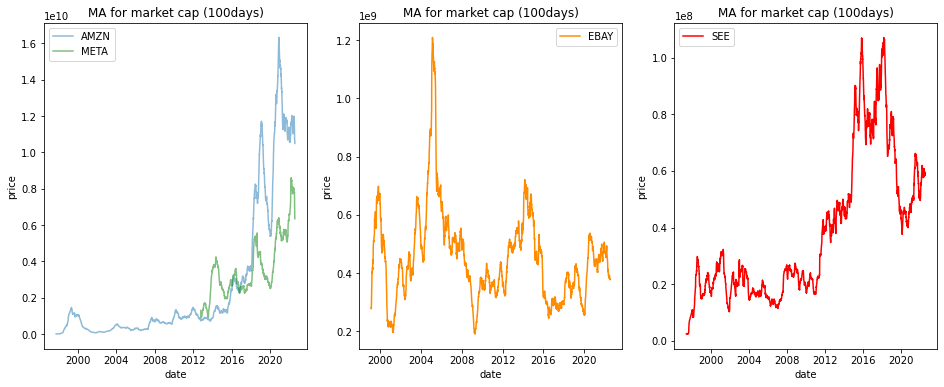

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
half_year_locator = mdates.YearLocator(4)

for i in range(len(axs)):
    axs[i].xaxis.set_major_locator(half_year_locator)
    axs[i].set_title('MA for market cap (100days)')
    axs[i].set_xlabel('date')
    axs[i].set_ylabel('price')
    if i == 0:
        axs[i].plot(df_amzn.index, df_amzn['MMC100'], label = 'AMZN', alpha=0.5)
        axs[i].plot(df_meta.index, df_meta['MMC100'], label = "META", color='green', alpha=0.5)
        axs[i].legend()
    elif i == 1:
        axs[i].plot(df_ebay.index, df_ebay['MMC100'], label = "EBAY", color='darkorange')
        axs[i].legend()
    else:
        axs[i].plot(df_see.index[df_see.index>=pd.to_datetime(since_date)], df_see['MMC100'][df_see.index>=pd.to_datetime(since_date)], label = "SEE", color='red')
        axs[i].legend()

Again we can use moving averages. Amazon and Meta have the highest market capitalization with an increasing tendency. Sealed Air has also noticed such a tendency with the lowest capitalization. EBay's price is pretty stable over the years, except for a pick in 2005.

Let's look at a percentage increase in stock value.

In [32]:
df_amzn['Volatility'] = (df_amzn['Close']/df_amzn['Close'].shift(1)) - 1
df_ebay['Volatility'] = (df_ebay['Close']/df_ebay['Close'].shift(1)) - 1
df_meta['Volatility'] = (df_meta['Close']/df_meta['Close'].shift(1)) - 1
df_see['Volatility'] = (df_see['Close']/df_see['Close'].shift(1)) - 1

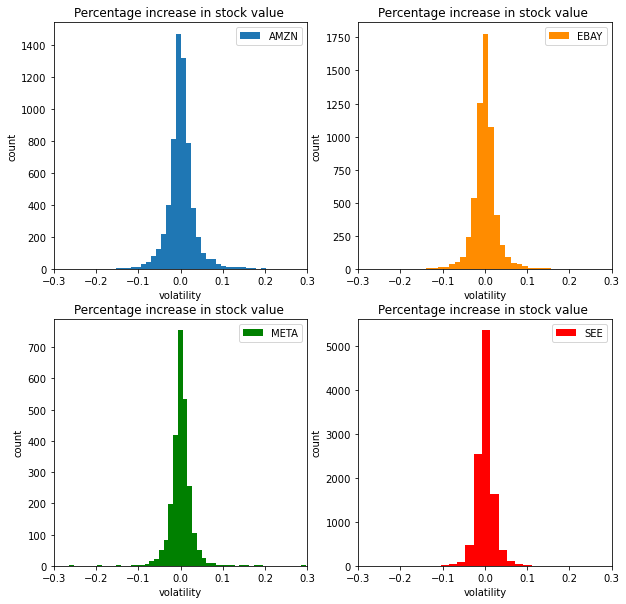

In [33]:
fig, axs = plt.subplots(2,2, figsize=(10, 10))

axs[0, 0].hist(df_amzn['Volatility'], bins=50, label='AMZN')
axs[0, 0].set_title('Percentage increase in stock value ')
axs[0, 0].set_xlabel('volatility')
axs[0, 0].set_ylabel('count')
axs[0, 0].set_xlim([-0.3, 0.3])
axs[0, 0].legend()

axs[0, 1].hist(df_ebay['Volatility'], bins=50, label='EBAY', color='darkorange')
axs[0, 1].set_title('Percentage increase in stock value ')
axs[0, 1].set_xlabel('volatility')
axs[0, 1].set_ylabel('count')
axs[0, 1].set_xlim([-0.3, 0.3])
axs[0, 1].legend()

axs[1, 0].hist(df_meta['Volatility'], bins=50, label='META', color='green')
axs[1, 0].set_title('Percentage increase in stock value ')
axs[1, 0].set_xlabel('volatility')
axs[1, 0].set_ylabel('count')
axs[1, 0].set_xlim([-0.3, 0.3])
axs[1, 0].legend()

axs[1, 1].hist(df_see['Volatility'], bins=50, label='SEE', color='red')
axs[1, 1].set_title('Percentage increase in stock value ')
axs[1, 1].set_xlabel('volatility')
axs[1, 1].set_ylabel('count')
axs[1, 1].set_xlim([-0.3, 0.3])
axs[1, 1].legend()

The histograms of SEE and META are less wide in comparison to others, which means the stock of Sealed Air and Meta are less volatile than Amazon and eBay. We can also calculate a variance of the Volatility column.

In [34]:
df_amzn['Volatility'].var()

0.001317950939427874

In [35]:
df_ebay['Volatility'].var()

0.0010397170584256115

In [36]:
df_meta['Volatility'].var()

0.0005962424436857819

In [37]:
df_see['Volatility'].var()

0.000468988203359811

<h2> Prepare the data </h2>

As we said before, we are dealing with unevenly spaced time series. In such a case analysis differ from a situation where data is evenly spaced. Additionally the pool of regressors that we can use is much restricted.

A common approach to deal with unevenly spaced time series is to transform the data to be evenly spaced. However we have to check an important thing.

<h3> Distribution of timesteps </h3>

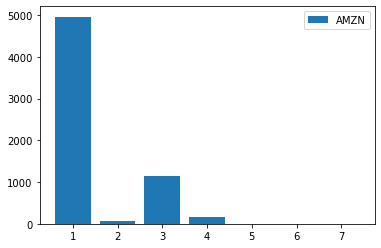

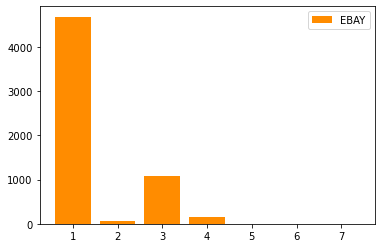

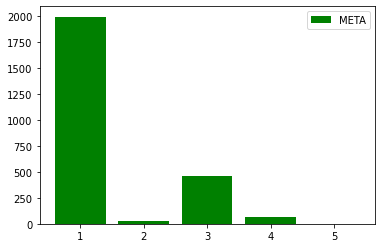

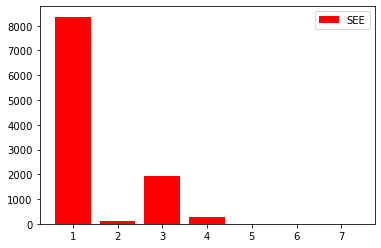

In [38]:
df_amzn = df_amzn.reset_index()
df_ebay = df_ebay.reset_index()
df_meta = df_meta.reset_index()
df_see = df_see.reset_index()

plt.bar((df_amzn['Date'] - df_amzn['Date'].shift(1)).value_counts().index.days, height=(df_amzn['Date'] - df_amzn['Date'].shift(1)).value_counts().values, label='AMZN')
plt.legend()
plt.show()
plt.bar((df_ebay['Date'] - df_ebay['Date'].shift(1)).value_counts().index.days, height=(df_ebay['Date'] - df_ebay['Date'].shift(1)).value_counts().values, color='darkorange', label='EBAY')
plt.legend()
plt.show()
plt.bar((df_meta['Date'] - df_meta['Date'].shift(1)).value_counts().index.days, height=(df_meta['Date'] - df_meta['Date'].shift(1)).value_counts().values, color='green', label='META')
plt.legend()
plt.show()
plt.bar((df_see['Date'] - df_see['Date'].shift(1)).value_counts().index.days, height=(df_see['Date'] - df_see['Date'].shift(1)).value_counts().values, color='red', label='SEE')
plt.legend()
plt.show()

As we can observe, timesteps has some variance in our datasets. However, it's probably a quantity that, at least, allows us to try on imputing method. However, this time we will practice neural networks and assumption about evenly spaced time series will be not necessary.

<h3> Create train and test sets. </h3>

Split dataset to training and testing set, that there is no nans in test_set from create_dataset function. Let's assume that 60 will be the biggest look_back number.

<h3> Feature scaling </h3>

In [39]:
X = df_amzn['Close']

split_on = int(0.8*X.shape[0]) - int(int(0.8*X.shape[0]) % 60)
X_to_train = X[:split_on]
X_to_test = X[split_on:]

In [40]:
scaler = StandardScaler()

X_to_train = scaler.fit_transform(X_to_train.to_numpy().reshape(-1, 1))
X_to_test = scaler.transform(X_to_test.to_numpy().reshape(-1, 1))

In [41]:
def create_dataset (X, look_back = 1):
    """
    Creates dataset, if the number of instances left is less than look_back, it adds Nones.
    """
    Xs, ys = [], []
    
    X = np.concatenate((X, np.array([None] * int(len(X) % look_back)).reshape([int(len(X) % look_back),1])))
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
                           
    return np.array(Xs), np.array(ys)

LOOK_BACK = 30

X_train, y_train = create_dataset(X_to_train, 60)
X_test, y_test = create_dataset(X_to_test, 60)


X_train.shape, X_test.shape

((4980, 60, 1), (1262, 60, 1))

<h2> Forecasting using RNNs with keras </h2>

A great architectures for time series data are RNNs, especially gated versions - GRU and LSTM. Since GRU is a bit simpler and easier to train (LSTM is more powerful and flexible), let's start with a GRU first.

After a first glance at the network settings, it turned out that:
    
- hidden layers: 1 or 2 seems good, 3 is too much for this problem (generally for such a problem 1 or 2 is sufficient)
    
- units: 40 to 100 works fine (generally 20-100 works fine)
    
- learning rate: around 0.0001 is good (generally it's good to take half of maximum learning rate, but adam is adaptive and doesn't need it that much)

- optimizer: adam, generally recommended as the default

- batch_size: should be in [10,32]

- output_activation_function: none, since the data was scaled and we want also negative numbers as an output

- epochs: large number, we will use early stopping

Now we can do a hyperparameter tuning.

In [67]:
class MyHyperModel(kt.HyperModel):
    
    def __init__(self):
        self.batch_size = None
        self.look_back = None
    def build(self, hp):
        units = hp.Int('units', min_value = 40, max_value = 100)
        learning_rate = hp.Float('learning_rate', 0.00005, 0.0005)
        num_layers = hp.Int("num_layers", 1, 2)
        self.batch_size = hp.Int('batch_size', min_value = 10, max_value = 32)
        self.look_back = hp.Int('look_back', min_value = 20, max_value = 40, step=10)
        
        model = Sequential()
        model.add(keras.layers.InputLayer(input_shape=[self.look_back, 1]))
        for i in range(num_layers):
            if num_layers - i != 1:
                model.add(keras.layers.GRU(units=units, activation='relu', return_sequences=True))

            else:
                model.add(keras.layers.GRU(units=units, activation='relu', return_sequences=False))
        model.add(keras.layers.Dense(1))

        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        # Warnings instead: https://gist.github.com/yoshihikoueno/4ff0694339f88d579bb3d9b07e609122
        optimizer.learning_rate = tf.Variable(optimizer.learning_rate)
        optimizer.beta_1 = tf.Variable(optimizer.beta_1)
        optimizer.beta_2 = tf.Variable(optimizer.beta_2)
        optimizer.iterations
        optimizer.decay = tf.Variable(0.0)
        
        model.compile(loss='mse', optimizer=optimizer, metrics=['mse', 'mae'])
        
        return model

    def fit(self, hp, model, x_to_split, *args, **kwargs):     
        
        x, y = create_dataset(x_to_split, self.look_back)
        
        # To prevent numpy error
        x = np.asarray(x).astype('float32')
        y = np.asarray(y).astype('float32')
        return model.fit(
            
            *args,
            x,
            y,
            batch_size = self.batch_size,
            use_multiprocessing = True,
            **kwargs,
        )

tuner = kt.BayesianOptimization(
    MyHyperModel(),
    objective="val_loss",
    max_trials=12, 
    overwrite=True,
    directory="tmp/tb",
    project_name="tuning1",
)

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

root_logdir = os.path.join(os.curdir, "tmp/tb_logs")
run_logdir = get_run_logdir() 
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

tuner.search(x_to_split=X_to_train, epochs=250,  callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=5), tensorboard_cb], validation_split=0.2)

# There will be some warnings because of TensorBoard usage: https://github.com/tensorflow/tensorflow/issues/37876
# which is not a bug.

Trial 12 Complete [00h 01m 18s]
val_loss: 0.05005229264497757

Best val_loss So Far: 0.005029553547501564
Total elapsed time: 00h 29m 55s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [68]:
best_model = tuner.get_best_models()[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0].values
print(best_hyperparameters)

{'units': 40, 'learning_rate': 5e-05, 'num_layers': 2, 'batch_size': 10, 'look_back': 20}


In [69]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 40)            5160      
                                                                 
 gru_1 (GRU)                 (None, 40)                9840      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 15,041
Trainable params: 15,041
Non-trainable params: 0
_________________________________________________________________


In [71]:
%load_ext tensorboard

%tensorboard --logdir tmp/tb_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 9620), started 0:00:03 ago. (Use '!kill 9620' to kill it.)

Since all of the best hyperparameters (of model with ID 10) are on a borders of the hyperparameter space, let's save the model and tune again, with a more sufficient space.

In [72]:
best_model.save('models/tune1/')
# model = keras.models.load_model('models/')

INFO:tensorflow:Assets written to: models/tune1/assets


INFO:tensorflow:Assets written to: models/tune1/assets


In [73]:
class MyHyperModel(kt.HyperModel):
    
    def __init__(self):
        self.batch_size = None
        self.look_back = None
    def build(self, hp):
        units = hp.Int('units', min_value = 20, max_value = 60)
        learning_rate = hp.Float('learning_rate', 0.00001, 0.0001)
        num_layers = hp.Int("num_layers", 1, 2)
        self.batch_size = hp.Int('batch_size', min_value = 10, max_value = 16)
        self.look_back = hp.Int('look_back', min_value = 10, max_value = 30, step=5)
        
        model = Sequential()
        model.add(keras.layers.InputLayer(input_shape=[self.look_back, 1]))
        for i in range(num_layers):
            if num_layers - i != 1:
                model.add(keras.layers.GRU(units=units, activation='relu', return_sequences=True))

            else:
                model.add(keras.layers.GRU(units=units, activation='relu', return_sequences=False))
        model.add(keras.layers.Dense(1))

        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        # Warnings instead: https://gist.github.com/yoshihikoueno/4ff0694339f88d579bb3d9b07e609122
        optimizer.learning_rate = tf.Variable(optimizer.learning_rate)
        optimizer.beta_1 = tf.Variable(optimizer.beta_1)
        optimizer.beta_2 = tf.Variable(optimizer.beta_2)
        optimizer.iterations
        optimizer.decay = tf.Variable(0.0)
        
        model.compile(loss='mse', optimizer=optimizer, metrics=['mse', 'mae'])
        
        return model

    def fit(self, hp, model, x_to_split, *args, **kwargs):     
        
        x, y = create_dataset(x_to_split, self.look_back)
        
        # To prevent numpy error
        x = np.asarray(x).astype('float32')
        y = np.asarray(y).astype('float32')
        return model.fit(
            
            *args,
            x,
            y,
            batch_size = self.batch_size,
            use_multiprocessing = True,
            **kwargs,
        )

tuner = kt.BayesianOptimization(
    MyHyperModel(),
    objective="val_loss",
    max_trials=12, 
    overwrite=True,
    directory="tmp/tb",
    project_name="tuning1",
)

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

root_logdir = os.path.join(os.curdir, "tmp/tb_logs")
run_logdir = get_run_logdir() 
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

tuner.search(x_to_split=X_to_train, epochs=250,  callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=5), tensorboard_cb], validation_split=0.2)

# There will be some warnings because of TensorBoard usage: https://github.com/tensorflow/tensorflow/issues/37876
# which is not a bug.

Trial 12 Complete [00h 00m 42s]
val_loss: 0.11632052809000015

Best val_loss So Far: 0.01770300790667534
Total elapsed time: 00h 17m 29s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [74]:
best_model = tuner.get_best_models()[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0].values
print(best_hyperparameters)

{'units': 41, 'learning_rate': 9.689681437216755e-05, 'num_layers': 1, 'batch_size': 14, 'look_back': 15}


In [75]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 41)                5412      
                                                                 
 dense (Dense)               (None, 1)                 42        
                                                                 
Total params: 5,454
Trainable params: 5,454
Non-trainable params: 0
_________________________________________________________________


In [76]:
%load_ext tensorboard

%tensorboard --logdir tmp/tb_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 9620), started 0:24:29 ago. (Use '!kill 9620' to kill it.)

Again, some of the hyperparameters on borders, however var_loss is higher. We will just accept the best model from a first tuning, since the results are well and it seems that hyperparameter tuning will not do its job.

Let's do a evaluation and prediction now, then plot results.

In [77]:
best_model.save('models/tune2/')
# model = keras.models.load_model('models/')

INFO:tensorflow:Assets written to: models/tune2/assets


INFO:tensorflow:Assets written to: models/tune2/assets


In [42]:
model = keras.models.load_model('models/tune1')

In [43]:
train_data = []
test_data = []
predictions = []
tests = []

In [67]:
X_amzn = df_amzn['Close']

split_on = int(0.8*X_amzn.shape[0]) - int(int(0.8*X_amzn.shape[0]) % 60)
X_to_train = X_amzn[:split_on]
X_to_test = X_amzn[split_on:]

train_data.append(X_to_train)
test_data.append(X_to_test)

X_to_train = scaler.fit_transform(X_to_train.to_numpy().reshape(-1, 1))
X_to_test = scaler.transform(X_to_test.to_numpy().reshape(-1, 1))

In [68]:
X_to_test.shape[0] % 20

11

In [69]:
X_to_test = X_to_test[:-11]

In [70]:
X_to_test.shape

(1280, 1)

In [71]:
X_train, y_train = create_dataset(X_to_train, 20)
X_test, y_test = create_dataset(X_to_test, 20)

In [72]:
y_test.shape, X_test.shape

((1260, 1), (1260, 20, 1))

In [73]:
model.evaluate(np.asarray(X_test).astype('float32'), np.asarray(y_test).astype('float32'))

40/40 [==============================] - 0s 5ms/step - loss: 3.8362 - mse: 3.8362 - mae: 1.7017


[3.836216449737549, 3.836216449737549, 1.701690435409546]

In [74]:
y_pred_train = model.predict(X_train)

In [75]:
X_train.shape, X_test.shape

((5020, 20, 1), (1260, 20, 1))

In [76]:
y_pred_test = model.predict(np.asarray(X_test).astype('float32'))

In [54]:
predictions.append(y_pred_test)
tests.append(y_test)

In [77]:
x1 = np.arange(X_train.shape[0])
x2 = np.arange(X_train.shape[0], X_train.shape[0] + X_test.shape[0])

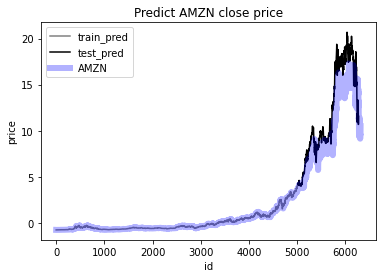

In [78]:
plt.plot(x1, y_pred_train, label='train_pred', color='grey')
plt.plot(x2, y_pred_test, label='test_pred', color='black')
plt.plot(df_amzn.index[:-11], np.concatenate((X_to_train, X_to_test), axis=0), label = 'AMZN', alpha=0.3, linewidth=6, color='blue')
plt.title('Predict AMZN close price')
plt.xlabel('id')
plt.ylabel('price')
plt.legend()

As we can see the model managed with the task pretty well, especially a shape of the plot looks very similar.

Let's check how well the model generalizes for other datasets.

39/39 [==============================] - 0s 5ms/step - loss: 0.3065 - mse: 0.3065 - mae: 0.3744
[0.30647704005241394, 0.30647704005241394, 0.3744460642337799]


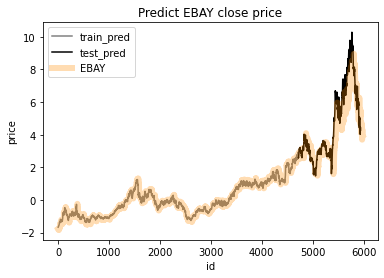

In [66]:
X_ebay = df_ebay['Close']

split_on = int(0.8*X_ebay.shape[0]) - int(int(0.8*X_ebay.shape[0]) % 60)
X_to_train = X_ebay[:split_on]
X_to_test = X_ebay[split_on:]

train_data.append(X_to_train)
test_data.append(X_to_test)

X_to_train = scaler.fit_transform(X_to_train.to_numpy().reshape(-1, 1))
X_to_test = scaler.transform(X_to_test.to_numpy().reshape(-1, 1))

remove = -(X_to_test.shape[0] % 20)
X_to_test = X_to_test[:remove]

X_train, y_train = create_dataset(X_to_train, 20)
X_test, y_test = create_dataset(X_to_test, 20)

print(model.evaluate(np.asarray(X_test).astype('float32'), np.asarray(y_test).astype('float32')))

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(np.asarray(X_test).astype('float32'))

predictions.append(y_pred_test)
tests.append(y_test)

x1 = np.arange(X_train.shape[0])
x2 = np.arange(X_train.shape[0], X_train.shape[0] + X_test.shape[0])

plt.plot(x1, y_pred_train, label='train_pred', color='grey')
plt.plot(x2, y_pred_test, label='test_pred', color='black')
plt.plot(df_ebay.index[:remove], np.concatenate((X_to_train, X_to_test), axis=0), label = 'EBAY', alpha=0.3, linewidth=6, color='darkorange')
plt.title('Predict EBAY close price')
plt.xlabel('id')
plt.ylabel('price')
plt.legend()

As we can see the results are much better this time, since tests stocks was clearly more predictable. Previous time, training data ended straight ahead amazons unusuall stocks picking, which might be not hard to be deducted by the model. This leads to some conclusions, which we will present later, in a summary.

15/15 [==============================] - 0s 4ms/step - loss: 0.0369 - mse: 0.0369 - mae: 0.1432
[0.036856524646282196, 0.036856524646282196, 0.14315390586853027]


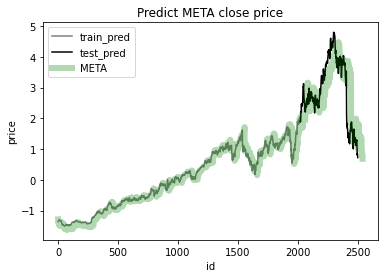

In [65]:
X_meta = df_meta['Close']

split_on = int(0.8*X_meta.shape[0]) - int(int(0.8*X_meta.shape[0]) % 60)
X_to_train = X_meta[:split_on]
X_to_test = X_meta[split_on:]

train_data.append(X_to_train)
test_data.append(X_to_test)

X_to_train = scaler.fit_transform(X_to_train.to_numpy().reshape(-1, 1))
X_to_test = scaler.transform(X_to_test.to_numpy().reshape(-1, 1))

remove = -(X_to_test.shape[0] % 20)
X_to_test = X_to_test[:remove]

X_train, y_train = create_dataset(X_to_train, 20)
X_test, y_test = create_dataset(X_to_test, 20)

print(model.evaluate(np.asarray(X_test).astype('float32'), np.asarray(y_test).astype('float32')))

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(np.asarray(X_test).astype('float32'))

predictions.append(y_pred_test)
tests.append(y_test)

x1 = np.arange(X_train.shape[0])
x2 = np.arange(X_train.shape[0], X_train.shape[0] + X_test.shape[0])

plt.plot(x1, y_pred_train, label='train_pred', color='grey')
plt.plot(x2, y_pred_test, label='test_pred', color='black')
plt.plot(df_meta.index[:remove], np.concatenate((X_to_train, X_to_test), axis=0), label = 'META', alpha=0.3, linewidth=6, color='green')
plt.title('Predict META close price')
plt.xlabel('id')
plt.ylabel('price')
plt.legend()

These result are pretty similar to ebay's.

67/67 [==============================] - 0s 5ms/step - loss: 0.1264 - mse: 0.1264 - mae: 0.2563
[0.12636935710906982, 0.12636935710906982, 0.2563120722770691]


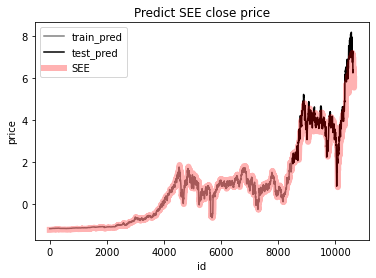

In [64]:
X_see = df_see['Close']

split_on = int(0.8*X_see.shape[0]) - int(int(0.8*X_see.shape[0]) % 60)
X_to_train = X_see[:split_on]
X_to_test = X_see[split_on:]

train_data.append(X_to_train)
test_data.append(X_to_test)

X_to_train = scaler.fit_transform(X_to_train.to_numpy().reshape(-1, 1))
X_to_test = scaler.transform(X_to_test.to_numpy().reshape(-1, 1))

remove = -(X_to_test.shape[0] % 20)
X_to_test = X_to_test[:remove]

X_train, y_train = create_dataset(X_to_train, 20)
X_test, y_test = create_dataset(X_to_test, 20)

print(model.evaluate(np.asarray(X_test).astype('float32'), np.asarray(y_test).astype('float32')))

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(np.asarray(X_test).astype('float32'))

predictions.append(y_pred_test)
tests.append(y_test)

x1 = np.arange(X_train.shape[0])
x2 = np.arange(X_train.shape[0], X_train.shape[0] + X_test.shape[0])

plt.plot(x1, y_pred_train, label='train_pred', color='grey')
plt.plot(x2, y_pred_test, label='test_pred', color='black')
plt.plot(df_see.index[:remove], np.concatenate((X_to_train, X_to_test), axis=0), label = 'SEE', alpha=0.3, linewidth=6, color='red')
plt.title('Predict SEE close price')
plt.xlabel('id')
plt.ylabel('price')
plt.legend()

Again.

<h2> Summary </h2>

At first, we did some EDA for unevenly space time series data. We pointed out that we can descirbe some of the data in time behaviours by global situations such as Covid-19. After that, timesteps distributions was calculated, we emphasized that its variation might be little enough to try on imputing method. On the other hand, one of the project goals was to use a neural network, which doesn't require such a transformations. We have decided to use RNNs gated version architecture, GRU, as a first model. We found a hints in a literature about hyperparameter tuning, which helps as to se the first hyperparameter space. Despite the fact that a model from first tuning has some hyperparameters on the borders, second tuning, with a potentially better parameter space, didn't improve that. Early stopping and tensorboard callbacks was used. Thanks to them, we didn't need to specify an ideal epoch count, additionally we were able to visualize a whole training process on the plots and tables. In the last stage, we have evaluated a model on the remaining Amazons data, after which we checked, how well the model generalize for other comapnies under consideration. We found out that the results for Amazon was the worst. This is probably, because in this case test data has much more variation, which model is not able to describe as a whole. We can see this below:

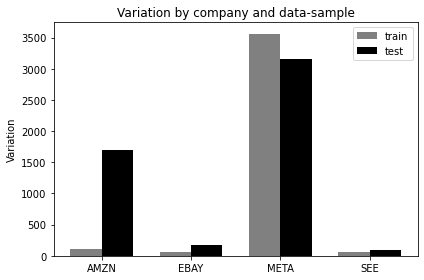

In [60]:
labels = ['AMZN', 'EBAY', 'META', 'SEE']
train_var = list(map(np.var, train_data))
test_var = list(map(np.var, test_data))


x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_var, width, label='train', color='gray')
rects2 = ax.bar(x + width/2, test_var, width, label='test', color='black')

ax.set_ylabel('Variation')
ax.set_title('Variation by company and data-sample')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()



fig.tight_layout()

plt.show()

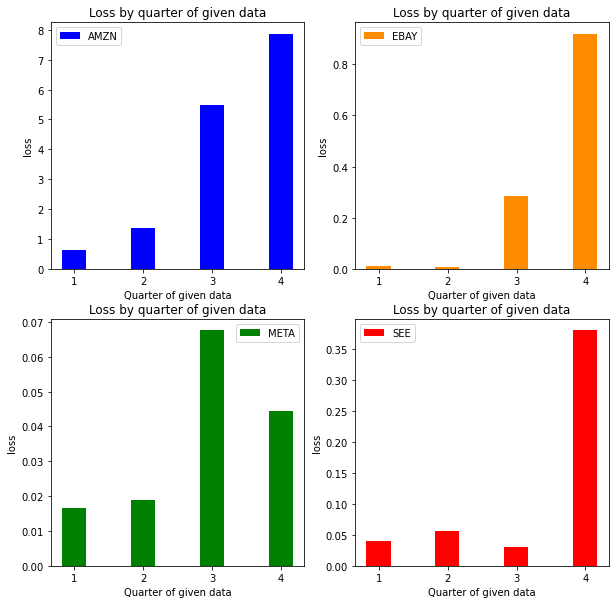

In [62]:
fig, axs = plt.subplots(2,2, figsize=(10, 10))
x = np.arange(len(labels))
colors = ['blue', 'darkorange', 'green', 'red']
mapping = {0: (0,0), 1: (0,1), 2: (1,0), 3: (1,1)}
for i in range(4):
    spaces = np.linspace(0, tests[i].shape[0], 5).astype(int)
    sample_mse = []
    for j in range(4):
        
        sample_mse.append(mean_squared_error(tests[i][spaces[j]:spaces[j+1]], predictions[i][spaces[j]:spaces[j+1]]))
    axs[mapping[i]].bar(x - width/2, sample_mse, width, label=labels[i], color=colors[i])
    axs[mapping[i]].set_title('Loss by quarter of given data')
    axs[mapping[i]].set_xticks(x-0.17)
    axs[mapping[i]].set_xticklabels([1,2,3,4])
    axs[mapping[i]].set_ylabel('loss')
    axs[mapping[i]].set_xlabel('Quarter of given data')
    axs[mapping[i]].legend()

As we can see, the further long-term data we want to predict, generally the higher the loss is. This shouldn't surprise us, because we start to predict based on predicted data. The additional factor that may "destroy" our predictions is large-scale emergencies. Such situations may have a very small probability, but for sure will happen, and the model is not able to predict when. That's why to get much better predictions, we should use live data and do a forecasting short-term.

<h2> Project conclusions </h2>

- using RNNS for unevenly spaced time series is easy, doesn't require additional transformations, and should get good results

- tensorboard provides a useful way to track model training and hyperparameter spaces

- early stopping callback is very useful in terms of time-saving

- it's useful to keep the same colour for each object for every plot

<h2> References </h2>

https://www.amazon.pl/Hands-Machine-Learning-Scikit-Learn-Tensorflow/dp/1492032646

https://towardsdatascience.com/preprocessing-time-series-data-for-supervised-learning-2e27493f44ae

https://stats.stackexchange.com/questions/312609/rnn-for-irregular-time-intervals

https://www.analyticsvidhya.com/blog/2021/07/stock-prices-analysis-with-python/

https://www.youtube.com/watch?v=E4NMZyfao2c

https://www.earthinversion.com/techniques/how-to-deal-with-irregular-sparse-data-set/

https://www.sciencedirect.com/science/article/abs/pii/S0925231221003003

https://www.youtube.com/watch?v=IV8--Y3evjw

https://towardsdatascience.com/predictive-analytics-time-series-forecasting-with-gru-and-bilstm-in-tensorflow-87588c852915

https://towardsdatascience.com/is-it-possible-to-predict-stock-prices-with-a-neural-network-d750af3de50b

https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607

https://github.com/keras-team/keras-tuner/issues/122

https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f

https://keras.io/guides/keras_tuner/visualize_tuning/